In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [42]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
N, D = tX.shape

In [4]:
df = pd.DataFrame(tX)
for col in df.columns:
    print(len(df[col].unique()), labels[col])
    if len(df[col].unique()) < 5:
        print (df[col].unique())

NameError: name 'labels' is not defined

In [5]:
labels = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]

### Exploratory data analysis

Find out how many datapoints are missing for each variable:

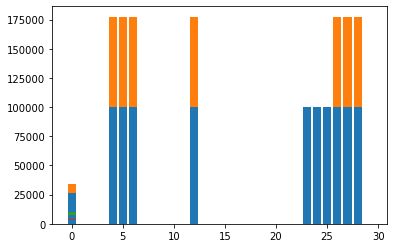

In [6]:
num_jets = labels.index("PRI_jet_num")
by_jet_num = [tX[np.where(tX[:, num_jets] == i)] for i in range(4)]
missing_counts = [np.count_nonzero(group == -999, axis=0) for group in by_jet_num]

plt.bar(np.arange(D), missing_counts[0])
for i in range(1, len(missing_counts)):
    plt.bar(np.arange(D), missing_counts[i], bottom=missing_counts[i-1])
plt.show()

Some notes:
* DER_* features are computed from the PRI_* features. This probably means we should ignore the PRI_* features, since they would most likely directly correlate to the DER_* ones. Luckily, they're already in the right order: there's 13 DER_* variables followed by PRI_* ones.
* All variables are continuous except the prediction and PRI_jet_num, which we shouldn't care about anyways.

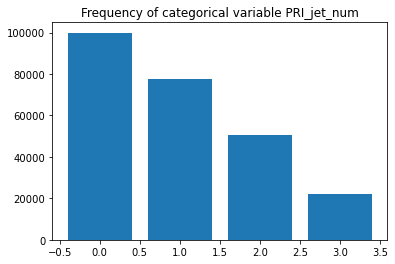

In [7]:
unique, counts = np.unique(tX[:,num_jets], return_counts=True)
plt.bar(unique, counts)
plt.title("Frequency of categorical variable PRI_jet_num")
plt.show()

## Plot data features with respect to each other

In [8]:
def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def correlate(feature1, feature2, size=None, axs=plt):
    valid = (feature1 != -999) & (feature2 != -999)
    feature1 = normalize(feature1[valid])
    feature2 = normalize(feature2[valid])
    if size is not None:
        perm = np.random.permutation(size)
        feature1 = feature1[perm]
        feature2 = feature2[perm]
    axs.scatter(feature1, feature2, s=1.5)

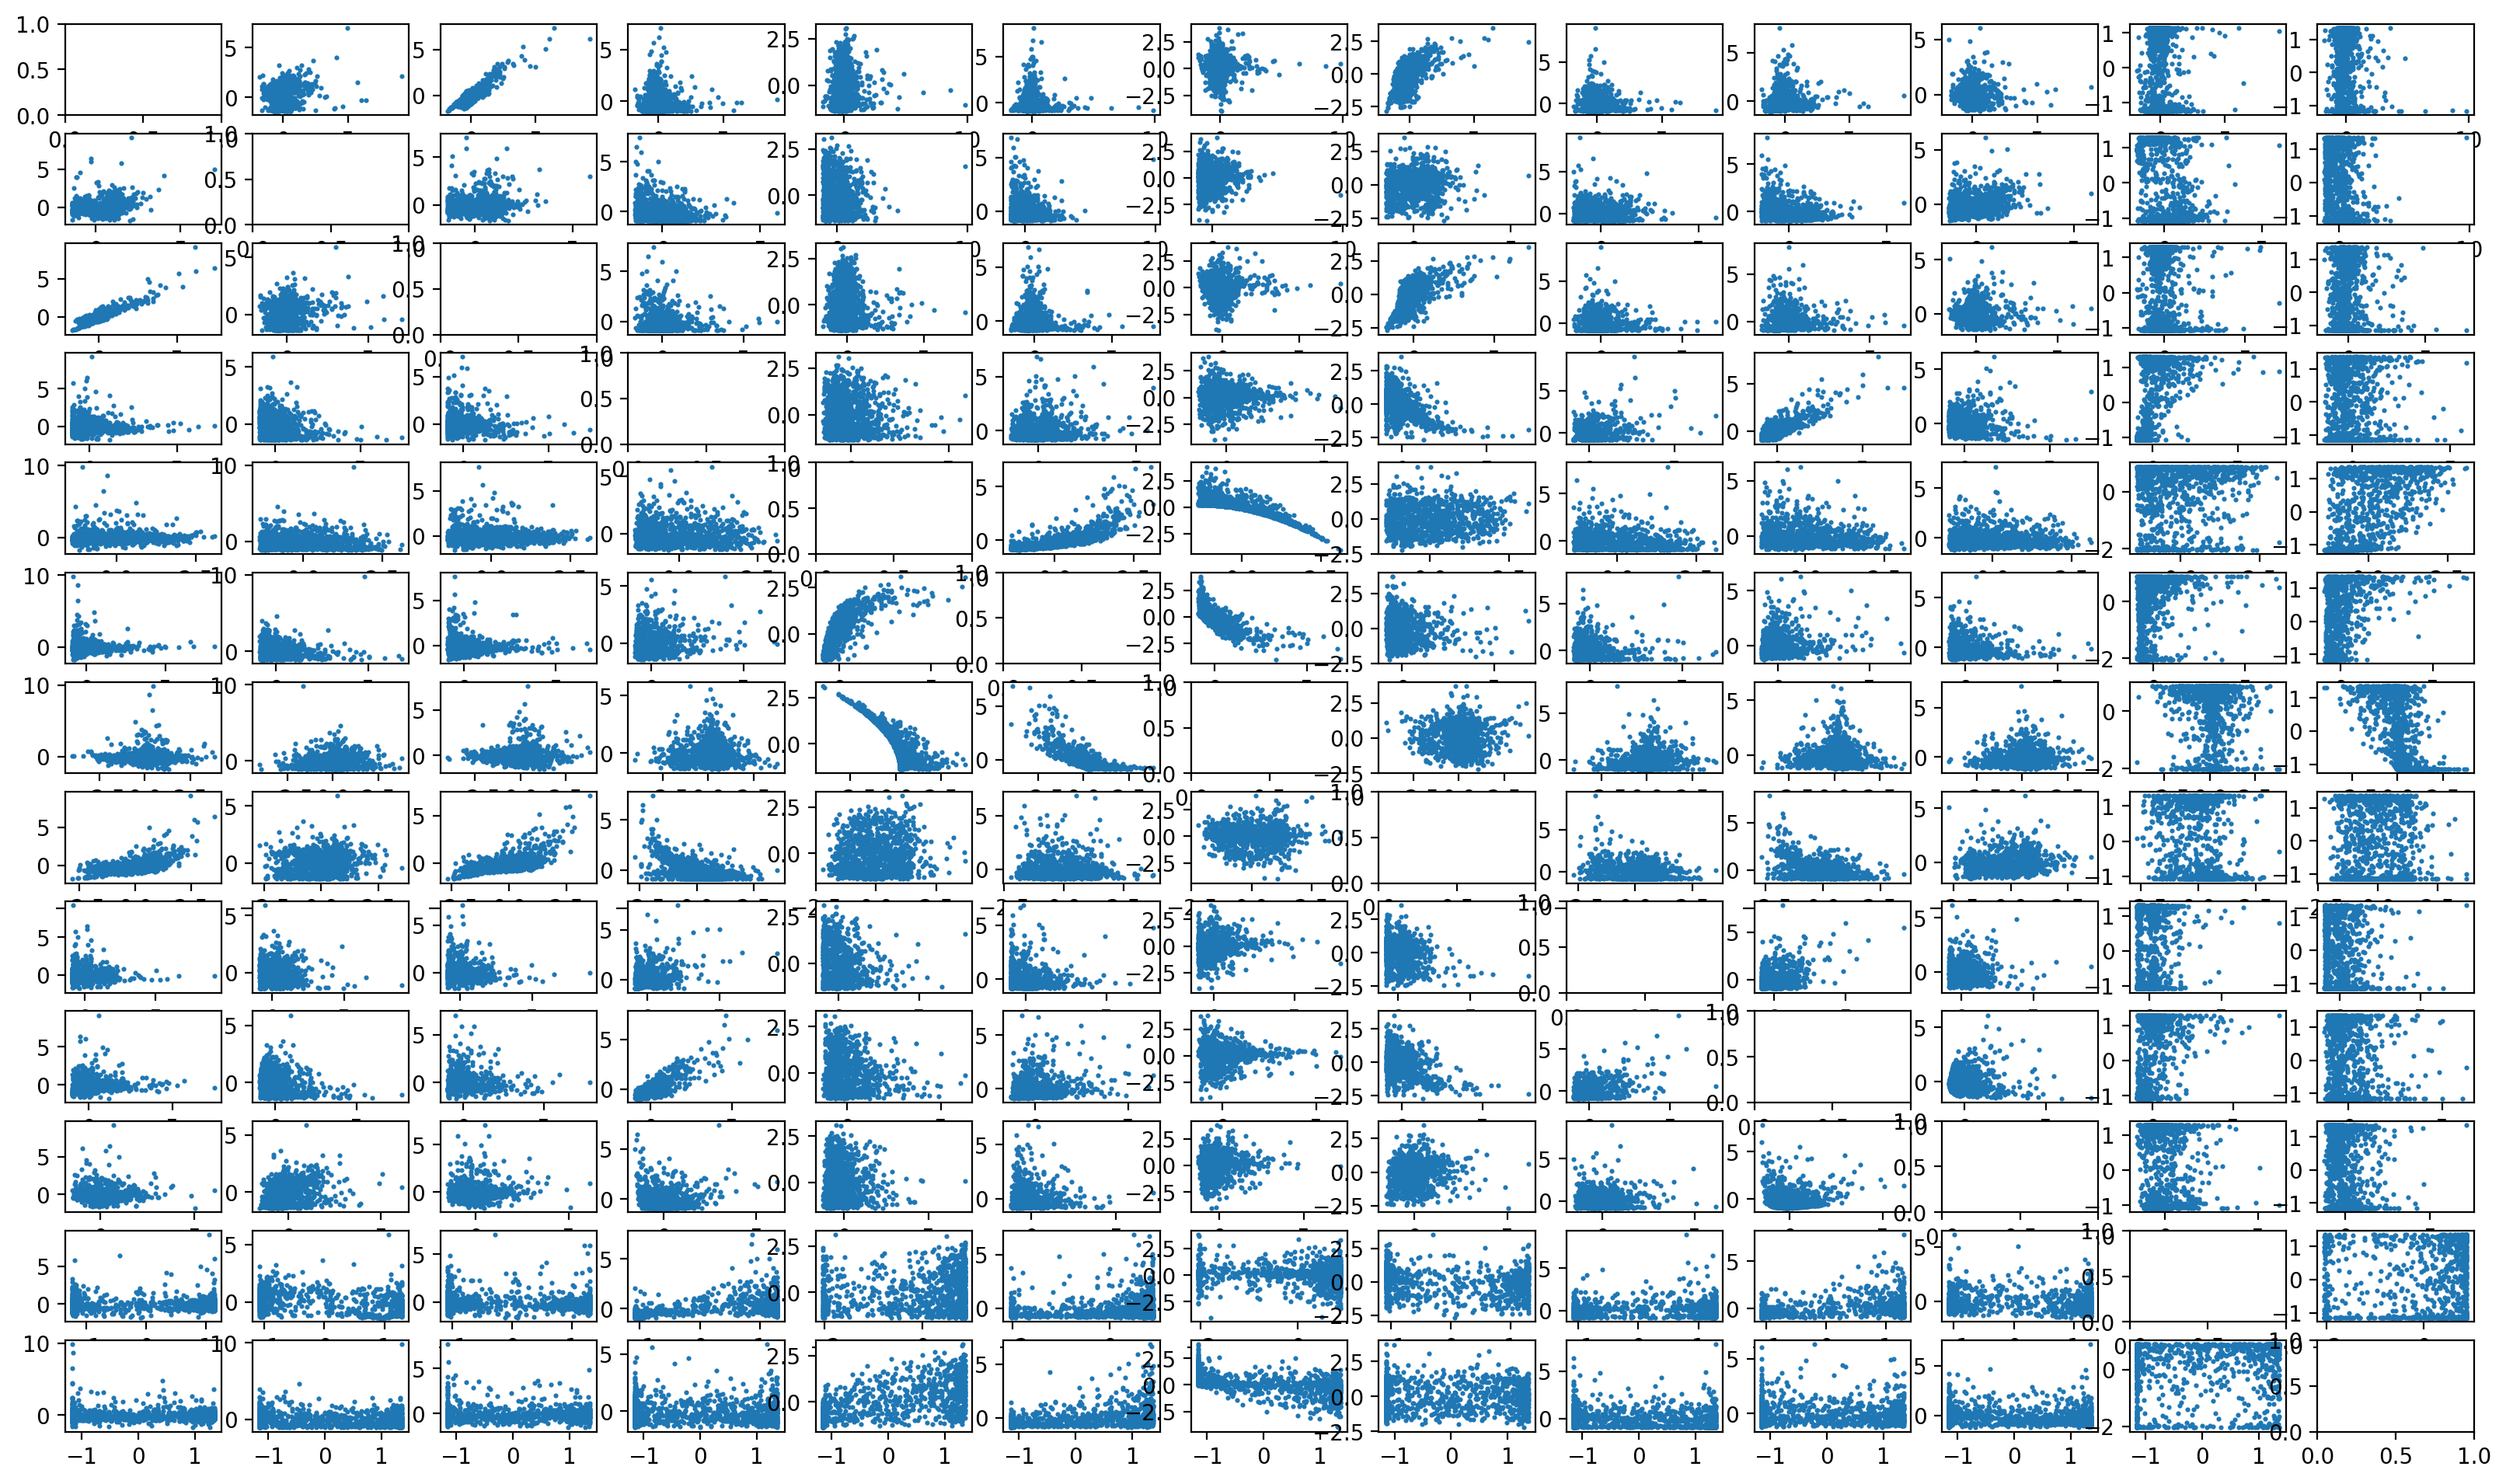

In [9]:
transposed = tX.T[:13]
fig = plt.figure(figsize=(20,12), dpi=200, facecolor='w', edgecolor='k')
axs = fig.subplots(13, 13)
for i, col1 in enumerate(transposed):
    for j, col2 in enumerate(transposed):
        if i != j:
            correlate(col1, col2, size=1000, axs=axs[i,j])

## Which features should be merged together?

In [10]:
def generate_correlation_set(tX, t):
    corr_set = set()
    df = pd.DataFrame(tX)
    corr = df.corr()
    for i, row in enumerate(corr):
        for j, col in enumerate(corr):
            if i != j and corr.loc[i,j] > t:
                corr_set.add((i,j))
                
    return _pairs_to_groups(corr_set)

def _pairs_to_groups(pairs):
    groups = set()
    edges = _create_dict_from_tuples(pairs)
    vertices = edges.keys()
    done = set()

    for vertex in vertices:
        if vertex not in done:
            groups.add(frozenset(_depth_first_search(vertex, edges, done)))

    return groups

def _depth_first_search(vertex, edges, done):
    group = {vertex}
    done.add(vertex)

    for v_adj in edges[vertex]:
        if v_adj not in done:
            group.update(_depth_first_search(v_adj, edges, done))

    return group

def _create_dict_from_tuples(tuples):
    dict_ = dict()

    for x, y in tuples:
        if x not in dict_:
            dict_[x] = set()
        dict_[x].add(y)

    return dict_

In [11]:
generate_correlation_set(tX, 0.96)

{frozenset({23, 24, 25}),
 frozenset({4, 6, 12, 26, 27, 28}),
 frozenset({9, 29})}

In [12]:
for s in generate_correlation_set(tX, 0.96):
    for i in s:
        print(labels[i])
    print()

PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_leading_pt

DER_deltaeta_jet_jet
DER_prodeta_jet_jet
PRI_jet_subleading_pt
PRI_jet_subleading_eta
DER_lep_eta_centrality
PRI_jet_subleading_phi

DER_sum_pt
PRI_jet_all_pt



# Notable correlation results

In [13]:
def correlate_features(i1, i2, size=None):
    plt.figure()
    plt.xlabel(labels[i1])
    plt.ylabel(labels[i2])
    correlate(tX[:,i1], tX[:,i2], size)

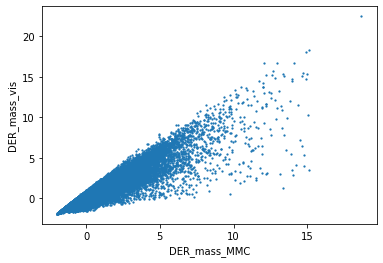

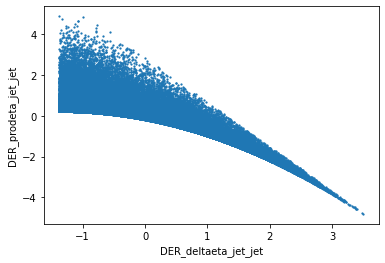

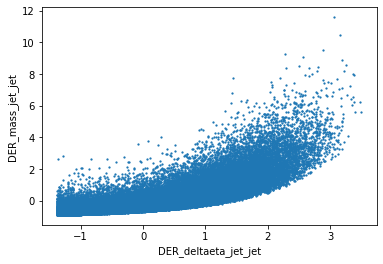

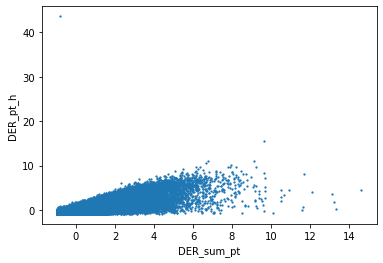

In [14]:
correlate_features(0, 2)
correlate_features(4, 6)
correlate_features(4, 5)
correlate_features(9, 3)

In [15]:
DATA_TEST_PATH = '../data/test.csv'
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

## Cleanup data and add constant factor

In [16]:
def normalize(tX):
    return (tX - np.mean(tX, axis=0)) / np.std(tX, axis=0)

def cleanup(tx):
    # Remove PRI_ features
    #tx = tx[:, :13]
    # Remove features that have lots of missing data
    #tx = np.delete(tx, [0, 4, 5, 6, 12], axis=1)
    # Normalize data
    tx = normalize(tx)
    # Add constant factor
    tx = np.c_[np.ones(tx.shape[0]), tx]
    return tx

""" Convert labels from {-1, 1} to {0, 1}. """
def normalize_labels(y):
    return np.round((y + 1) / 2)

In [51]:
y_log = normalize_labels(y)
tx_clean = cleanup(tX)

## Tune hyperparameters

In [18]:
from validation import *
indices = build_k_indices(y_log, 6)

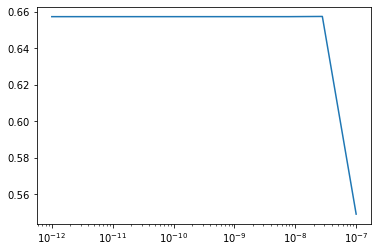

In [19]:
from implementations import *

initial_w = np.zeros(tx_clean.shape[1])
gammas = np.logspace(-12, -7, num=10)

best_idx, results = optimize_hyperparameter(y_log, tx_clean, gammas, indices,
    lambda y, tx, gamma: logistic_reg_GD(y, tx, initial_w, 30, gamma))

plt.semilogx(gammas, results)
plt.show()

## Run all models and compare their accuracy

In [80]:
initial_w = np.zeros(tx_clean.shape[1])
results = np.array([
    cross_validation(y_log, tx_clean, indices, lambda y, tx: least_squares_GD(y, tx, initial_w, 100, 0.1)),
    cross_validation(y_log, tx_clean, indices, least_squares),
    cross_validation(y_log, tx_clean, indices, lambda y, tx: ridge_regression(y, tx, 0.01)),
    cross_validation(y_log, tx_clean, indices, lambda y, tx: penalized_logistic_reg_GD(y, tx, initial_w, 100, 1e-8, 1e-5))
])

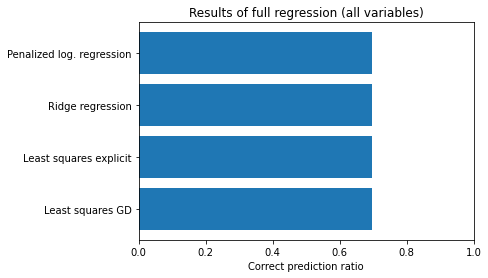

In [81]:
# Plot the results
names = ["Least squares GD", "Least squares explicit", "Ridge regression", "Penalized log. regression"]
plt.barh(names, results)
plt.xlim(0, 1)
plt.xlabel("Correct prediction ratio")
plt.title("Results of full regression (all variables)")
plt.show()

In [191]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
N, D = tX.shape

In [192]:
categorical_index = labels.index("PRI_jet_num")
useless_features = {
    0: ["DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet", "DER_lep_eta_centrality",
        "PRI_jet_leading_pt", "PRI_jet_leading_eta", "PRI_jet_leading_phi",
        "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi","PRI_jet_all_pt"
       ],
    1: ["DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet", "DER_lep_eta_centrality",
        "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi"
       ],
    2: [],
    3: []
}


def group_by_jet_num(y, tx, jet_num):
    indices = np.where(tx[:, categorical_index] == jet_num)
    useless = useless_features[jet_num] + ["PRI_jet_num"]
    useless_indices = [labels.index(feat) for feat in useless]
    tx_ = np.delete(tx, useless_indices, axis=1)
    return [y[indices], tx_[indices]]

def group_data(y, tx):
    data_grouped = [
        group_by_jet_num(y, tx, jet_num)
        for jet_num in range(4)
    ]
    # Create one single group for jet_nums 2 and 3
    data_grouped[2][0] = np.concatenate([data_grouped[2][0], data_grouped[3][0]])
    data_grouped[2][1] = np.concatenate([data_grouped[2][1], data_grouped[3][1]])
    data_grouped.pop(3)
    return data_grouped

data_grouped = group_data(y, tX)

In [205]:
def polynomial_expansion(tx, degree):
    powers = [np.power(tx, i) for i in range(2, degree)]
    return [tx] + powers


def feature_expansion(tx):
    #tx = np.concatenate(polynomial_expansion(tx, 7) + [np.sin(tx), np.log(np.abs(tx) + 1e-10)],axis=1)
    return cleanup(tx)


avg_acc = 0.0
for y, tx in data_grouped:
    tx = feature_expansion(tx)
    # No need to normalize since we only use least squares; y = normalize_labels(y)
    indices = build_k_indices(y, 10)
    avg_acc += cross_validation(y, tx, indices, least_squares)
avg_acc / len(data_grouped)

0.7528769644702988

In [206]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv"
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)

def calculate_weights(y, tx):     
    tx = feature_expansion(tx)
    weights, _ = least_squares(y, tx)
    return weights

w_by_group = [calculate_weights(y, tx) for y, tx in group_data(y, tx)]

In [207]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [209]:
OUTPUT_PATH = 'predictions.csv'

def predict_labels_grouped(w_by_group, ids, data):
    """Generates class predictions given weights, and a test data matrix"""
    data_grouped = group_data(ids, data) # List[ (Id, tX)]
    y_pred = np.array([])
    ids_pred = np.array([])
    for group, w in zip(data_grouped, w_by_group):
        ids, tx = group
        tx = feature_expansion(tx)
        y_pred = np.concatenate([y_pred, tx @ w])
        ids_pred = np.concatenate([ids_pred, ids])
    y_pred[y_pred > 0] = 1
    y_pred[y_pred <= 0] = -1
    return y_pred, ids_pred

y_pred, ids_pred = predict_labels_grouped(w_by_group, ids_test, tX_test)
create_csv_submission(ids_pred, y_pred, OUTPUT_PATH)